In [331]:
import os
from typing import *
import operator
from urllib.request import build_opener

from docutils.nodes import system_message
from dotenv import load_dotenv
from numba.np.ufunc.parallel import build_gufunc_kernel
from torch.jit.frontend import build_def

load_dotenv()
from IPython.display import Image, display, Markdown
import sqlite3
from pydantic import BaseModel, Field


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage, get_buffer_string
# from langchain_community.tools import TavilySearchResults
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.types import interrupt, Command
from langgraph.constants import Send

In [332]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")

max_analysts = 3
# topic = "The benefits of adopting LangGraph as an agent framework"
# topic = "The benefits of using Multi-Agent Pathfinding framework"
topic = "The situation of the Tel Aviv stock market this week"
thread = {'configurable': {'thread_id': '1'}}


analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


search_instructions = f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""


section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""


intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [333]:
# ------------------------------------------------------ #
# MODELS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')

In [334]:
# ------------------------------------------------------ #
# TOOLS
# ------------------------------------------------------ #
# tavily_search = TavilySearchResults(max_results=3)
tavily_search = TavilySearch(
    max_results=3,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [335]:
# ------------------------------------------------------ #
# STATES
# ------------------------------------------------------ #
# --------------------------- #
# STATES - GENERATE ANALYSTS
# --------------------------- #
class Analyst(BaseModel):
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    @property
    def persona(self) -> str:
        return (f"Name: {self.name}\n"
                f"Role: {self.role}\n"
                f"Affiliation: {self.affiliation}\n"
                f"Description: {self.description}\n")


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")


class GenerateAnalystsState(TypedDict):
    topic: str  # research topic
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

# --------------------------- #
# STATES - GENERATE INTERVIEWS
# --------------------------- #
class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list


class SearchQuery(BaseModel):
    search_query: str = Field(description="Search query for retrival.")

# --------------------------- #
# STATES - GENERAL
# --------------------------- #
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [336]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
# --------------------------- #
# NODES - GENERATE ANALYSTS
# --------------------------- #
def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    structured_llm = chat_llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(topic=topic, human_analyst_feedback=human_analyst_feedback, max_analysts=max_analysts)

    analysts: Perspectives = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

    return {'analysts': analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass


# --------------------------- #
# NODES - GENERATE INTERVIEWS
# --------------------------- #
def generate_question(state: InterviewState):
    """Node to generate question."""
    analyst = state['analyst']
    messages = state['messages']

    system_message = question_instructions.format(goals=analyst.persona)
    question = chat_llm.invoke([SystemMessage(content=system_message)] + messages)
    return {'messages': [question]}


def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    structured_llm = chat_llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions)] + state['messages'])

    search_docs = tavily_search.invoke({"query": search_query.search_query})
    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )
    formatted_search_docs = "\n\n---\n\n"
    for doc in search_docs['results']:
        formatted_search_docs += \
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'

    return {'context': [formatted_search_docs]}


def search_wikipedia(state: InterviewState):
    """Retrieve docs from wikipedia"""
    structured_llm = chat_llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([SystemMessage(content=search_instructions)] + state['messages'])

    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {'context': [formatted_search_docs]}


def generate_answer(state: InterviewState):
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']

    system_messages = answer_instructions.format(goals=analyst.persona, context=context)
    answer = chat_llm.invoke([SystemMessage(content=system_messages)] + messages)
    answer.name = 'expert'

    return {'messages': [answer]}


def save_interview(state: InterviewState):
    messages = state['messages']
    # Convert interview to a string
    interview = get_buffer_string(messages)
    return {'interview': interview}


def write_section(state: InterviewState):
    interview = state['interview']
    context = state['context']
    analyst = state['analyst']

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = chat_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your section: {context}")])
    return {'sections': [section.content]}


# --------------------------- #
# NODES - GENERAL
# --------------------------- #
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = chat_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}


def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = chat_llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = chat_llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


In [337]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #
# --------------------------- #
# GENERATE ANALYSTS
# --------------------------- #
def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return 'create_analysts'
    return END


# --------------------------- #
# GENERATE INTERVIEWS
# --------------------------- #
def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)

    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "generate_question"


# --------------------------- #
# GENERAL
# --------------------------- #
def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]


In [338]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
def create_analysts_builder():
    builder = StateGraph(GenerateAnalystsState)
    # nodes
    builder.add_node(create_analysts)
    builder.add_node(human_feedback)
    # edges
    builder.add_edge(START, 'create_analysts')
    builder.add_edge('create_analysts', 'human_feedback')
    builder.add_conditional_edges('human_feedback', should_continue, ['create_analysts', END])
    return builder


def create_interview_builder():
    builder = StateGraph(InterviewState)
    # nodes
    builder.add_node(generate_question)
    builder.add_node(search_web)
    builder.add_node(search_wikipedia)
    builder.add_node(generate_answer)
    builder.add_node(save_interview)
    builder.add_node(write_section)
    # edges
    builder.add_edge(START, 'generate_question')
    builder.add_edge('generate_question', 'search_web')
    builder.add_edge('generate_question', 'search_wikipedia')
    builder.add_edge('search_web', 'generate_answer')
    builder.add_edge('search_wikipedia', 'generate_answer')
    builder.add_conditional_edges('generate_answer', route_messages, ['generate_question', 'save_interview'])
    builder.add_edge('save_interview', 'write_section')
    builder.add_edge('write_section', END)

    return builder

def create_general_builder():
    builder = StateGraph(ResearchGraphState)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("human_feedback", human_feedback)
    builder.add_node("conduct_interview", create_interview_builder().compile())
    builder.add_node("write_report",write_report)
    builder.add_node("write_introduction",write_introduction)
    builder.add_node("write_conclusion",write_conclusion)
    builder.add_node("finalize_report",finalize_report)

    # Logic
    builder.add_edge(START, "create_analysts")
    builder.add_edge("create_analysts", "human_feedback")
    builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
    builder.add_edge("conduct_interview", "write_report")
    builder.add_edge("conduct_interview", "write_introduction")
    builder.add_edge("conduct_interview", "write_conclusion")
    builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
    builder.add_edge("finalize_report", END)
    return builder

In [339]:
# ------------------------------------------------------ #
# MEMORY
# ------------------------------------------------------ #
memory = MemorySaver()

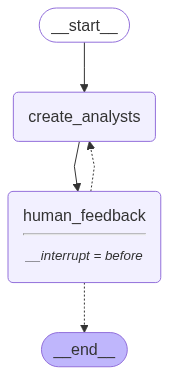

In [340]:
# ------------------------------------------------------ #
# COMPILE
# ------------------------------------------------------ #
graph = create_analysts_builder().compile(interrupt_before=['human_feedback'], checkpointer=memory)
# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [341]:
# ------------------------------------------------------ #
# INVOCATIONS
# ------------------------------------------------------ #
# for event in graph.stream({'topic': topic, 'max_analysts': max_analysts,}, thread, stream_mode="values"):
#     analysts = event.get('analysts', '')
#     if analysts:
#         for analyst in analysts:
#             print(f"Name: {analyst.name}")
#             print(f"Affiliation: {analyst.affiliation}")
#             print(f"Role: {analyst.role}")
#             print(f"Description: {analyst.description}")
#             print("-" * 50)

In [342]:
# state = graph.get_state(thread)
# state.next

In [343]:
# graph.update_state(thread, {'human_analyst_feedback': "Add in someone from a strartup to add an entrepreneur perspective."}, as_node='human_feedback')

In [344]:
# for event in graph.stream(None, thread, stream_mode="values"):
#     analysts = event.get('analysts', '')
#     if analysts:
#         print("vvv" * 50)
#         for analyst in analysts:
#             print(f"Name: {analyst.name}")
#             print(f"Affiliation: {analyst.affiliation}")
#             print(f"Role: {analyst.role}")
#             print(f"Description: {analyst.description}")
#             print("-" * 50)
#         print("^^^" * 50)

In [345]:
# graph.update_state(thread, {'human_analyst_feedback': None}, as_node='human_feedback')

In [346]:
# for event in graph.stream(None, thread, stream_mode="values"):
#     print('--- Node ---')
#     node_name = next(iter(event.keys()))
#     print(node_name)

In [347]:
# final_state = graph.get_state(thread)
# final_state.next

In [348]:
# analysts = final_state.values.get('analysts')
# for analyst in analysts:
#     print(f"Name: {analyst.name}")
#     print(f"Affiliation: {analyst.affiliation}")
#     print(f"Role: {analyst.role}")
#     print(f"Description: {analyst.description}")
#     print("-" * 50)

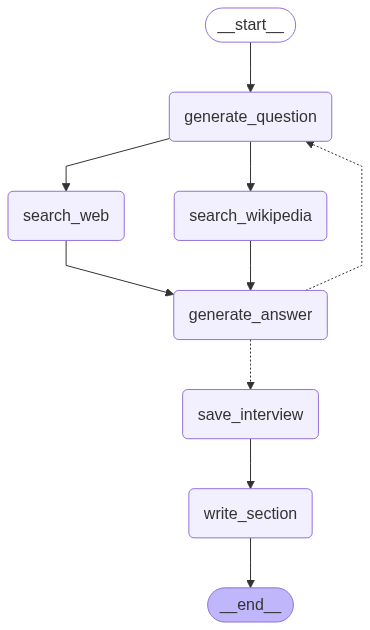

In [349]:
# ------------------------------------------------------ #
# COMPILE - INTERVIEWS
# ------------------------------------------------------ #
interview_graph = create_interview_builder().compile(checkpointer=memory).with_config(run_name='Conduct Interviews')
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))

In [350]:
# ------------------------------------------------------ #
# INVOCATIONS - INTERVIEWS
# ------------------------------------------------------ #
# analysts[0]

In [351]:
# messages = [HumanMessage(content=f"So you said you were working on {topic}?")]
# interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
# Markdown(interview['sections'][0])

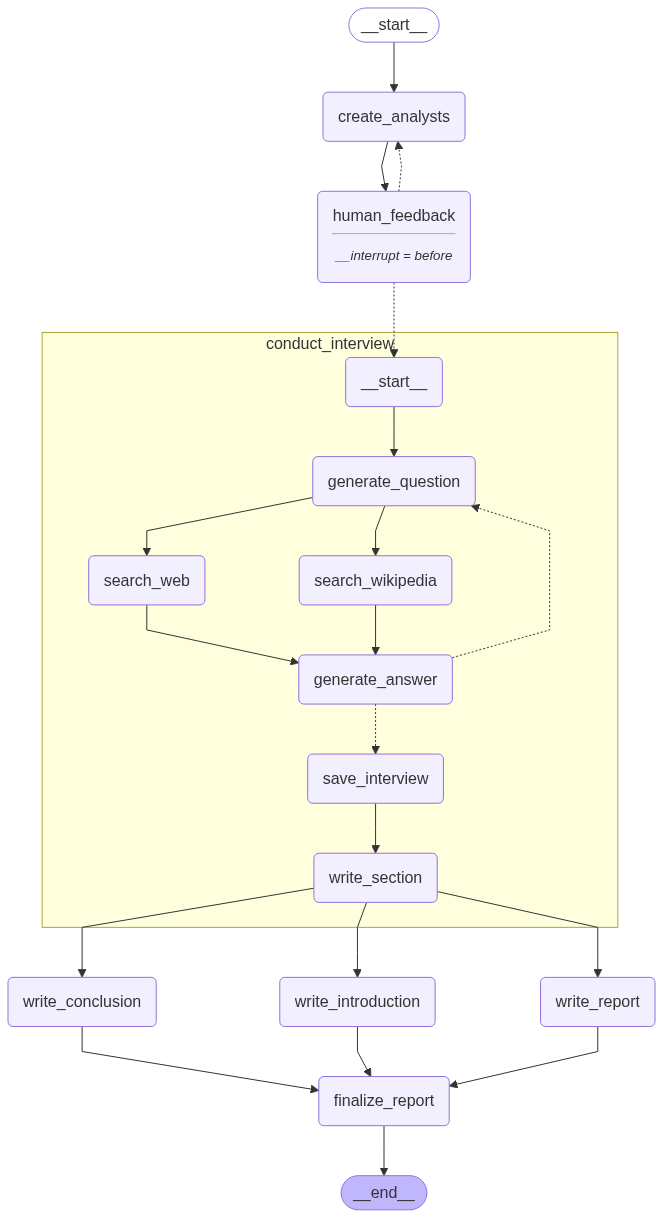

In [352]:
graph = create_general_builder().compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [353]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Kim
Affiliation: Research Scientist
Role: Technical Expert
Description: A leading expert in AI and LangGraph, Dr. Kim has extensive experience in developing and implementing agent frameworks for complex systems.
--------------------------------------------------
Name: Alex Chen
Affiliation: Business Analyst
Role: Practical Expert
Description: With a background in business operations, Alex brings a practical perspective to the adoption of LangGraph, focusing on its potential impact on organizational efficiency and productivity.
--------------------------------------------------
Name: Dr. Liam Patel
Affiliation: Researcher
Role: Theoretical Expert
Description: A theoretical computer scientist with a focus on AI and machine learning, Dr. Patel is well-versed in the underlying mathematics and algorithms that underpin LangGraph's agent framework.
--------------------------------------------------


In [354]:
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04dbf7-7434-6f56-8002-fc136db09279'}}

In [355]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Kim
Affiliation: Research Scientist
Role: Technical Expert
Description: A leading expert in AI and LangGraph, Dr. Kim has extensive experience in developing and implementing agent frameworks for complex systems.
--------------------------------------------------
Name: Alex Chen
Affiliation: Business Analyst
Role: Practical Expert
Description: With a background in business operations, Alex brings a practical perspective to the adoption of LangGraph, focusing on its potential impact on organizational efficiency and productivity.
--------------------------------------------------
Name: Dr. Liam Patel
Affiliation: Researcher
Role: Theoretical Expert
Description: A theoretical computer scientist with a focus on AI and machine learning, Dr. Patel is well-versed in the underlying mathematics and algorithms that underpin LangGraph's agent framework.
--------------------------------------------------
Name: Dr. Rachel Kim
Affiliation: LangGraph Research Team
Role: Lead Researche

In [356]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04dbf7-eaf3-6066-8004-d0c200160137'}}

In [357]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

KeyError: 'results'

In [ ]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)